In [106]:
import numpy as np 
from matplotlib import pyplot as plt
import random
import copy

In [107]:
# ----
# Objective: See figure in assignent.
# If the earth has density differences, DeltaRho, measured with respect to the normal density, the gravitational constant will change depending on where youre standing.
# We will model the earth with a vertical faultline. To the left of this faultline, DeltaRho=0, while to the right DeltaRho≠0. 
# DeltaRho is assumed a constant along the horizontal, while it changes discretely at certain depths h_j. Therefore DeltaRho takes discrete values DeltaRho=DeltaRho_j.
#
# The gravitational constant gradient along the surface is given in the assignment.
# Knowing h_j and DeltaRho_j, one may thus reconstruct d(x) where x is the distance from the fault to the observation points along the surface of the Earth.


# We are however interested in the inverse problem: Knowing d(x)=d(x_i) at discrete points i, we would like to know h_j and DeltaRho_j. d(x) is assumed to be produced in actual values ({h_i_actual}, {DeltaRho_i_actual})


# One may solve this problem in the following way: Indifferent to d(x), there may be (priori) limitations on the values of h and DeltaRho. We will assume that
# 2km <= h_j <= 10 km
# -2000 kg/m3 <= DeltaRho_j <= 2000 kg/m3
# with an equal (priori) probability \rho(h,DeltaRho) for all values herein.

# However, given that we have observed d(x), the probability for each value changes. Using Bayes, and writing m=(h,DeltaRho) as a shorthand for a full set of values of {h_i,DeltaRho_i}, one may write
#\sigma(m)=\rho(m)*L(m)
#where sigma is the porbability of measuring m, given the actual observations d(x) and L(m) is the likelihood function, describing how observations d(x) changes the priori probability \rho(m).
# L(m) is defined by eq. (1) in the problemset. L(m) encapsulates all relation between m and the actual observations m_actual=(h_actual,DeltaRho_actual). 
# One may from L(m) thus define a missfit function
# S=-ln(L)
# to quantify how well m approximates m_actual.


# one may thus propose the following algorithm for finding a nice approximation to m_actual:
# 1) Consider a physically realisable m=({h_j},{DeltaRho_j}) which approximates m_actual. ´Physically realisable´ means \rho(m)≠0. Call it m_k and write it as a vector of DeltaRho_j and h_j. 
#  We would like to find an even better approximation, call it m_(k+1), than this one. This is what the algorithm below does. 
#  Perturb m_k slightly by choosing a single h_j or DeltaRho_j, adding to it [-l,l] for some fixed l.
#  Check that the perturbed m_perturb is still physically realisable by checking /rho(m_perturb)≠0.
# 2) We would now like to relate m_k to the actual m_actual. To do this, compute S(m_perturb). 
# Is this better or worse than S(m_k)? We need an acceptance algorithm to decide whether m_perturb is better.
#.  The algorithm for accepting m_perturb as a better approximation than m_k:
#.     If S(m_perturb)>S(m_k): ((meaning it is doubtful that m_perturb is better than m_k )):
#.         p_accept = eq. (4) line 1
#.     If S(m_perturb<S(m_k)): ((meaning m_perturb is definitely a better approxiation to m_actual than m_k)):
#.         p_accept = 1    ((immediately accept the new m since it is better than the old one ))

# 3) If m_perturb has been accepted, set m_(k+1)=m_perturb, otherwise keep the old value, m_(k+1)=m_k.
# 4) Repeat steps 1-3 with m_(k+1) to gradually find better and better approximations for m_actual.

#
# ----
#
#

In [108]:
# load observation data
Data = np.loadtxt('gravdata.txt')
d_obs = Data[:,1]
x_obs = Data[:,0]
G=6.67430*10**(-11)
s=10**(-9) # units [s**(-2)]
#print(d_obs)

# usefull functions
def d(m):
    # m is a vector of (DeltaRho,h)
    d=[]
    DeltaRho = m[:int(len(m)/2)]
    h = m [int(len(m)/2):]
    for x_i in x_obs:
        # find d_i=d(x_i)
        d_i=0
        z_top=0
        for thickness,deltarho in zip(h,DeltaRho):
            d_i += G*deltarho*np.log(((z_top+thickness)**2+x_i**2)/(z_top**2+x_i**2)) # z_base = z_top + thickness, G is just proportionality constant and is neglected
            z_top += thickness
        d.append(d_i)
    #print(d)
    return np.array(d)
    

def L(m):
    return np.exp(-np.sum(np.square(d_obs-d(m)))/s**2)

layers=100
#generate random sample obeying DeltaRho and h boundaries (meaning they are physically ok)
Delta_Rho = np.random.uniform(low=-50, high=50, size = layers) # unit = [kg/m**3], uses 1/100 of physically ok interval
#Delta_Rho = np.arange(0,layers)
h = np.random.uniform(low=3*1000, high=4*1000,  size = layers) # unit = [m], uses 1/100 of physically ok interval
#h = np.arange(0,layers)
# calculate how well (DeltaRho,h) approximate actual observations d(x)
m_reference=np.append(Delta_Rho,h)
#print(m_reference)

def S_from_L(m):
    return -np.log(L(m))

def S(m):
    return np.sum(np.square(d_obs-d(m)))/s**2

def check_physical(m):
    m=np.array(m)
    if all(np.abs(m[0:int(len(m)/2)])<=2000) and all(m[int(len(m)/2)::]<=10*1000) and all(m[int(len(m)/2)::]>=2*1000):
        return True
    else: 
        return False
#check_physical([-1,4000])

non-physical m_pert
non-physical m_pert
non-physical m_pert
non-physical m_pert
acceptance probability 99.0


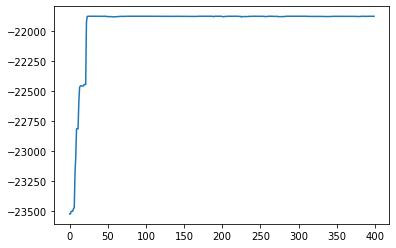

In [109]:
number_of_steps = 400
i=0
#print(m_reference)
m=copy.deepcopy(m_reference)
log_l_m=np.array([])
accepted=0
while i < number_of_steps:
    #print()
    # perturb m to create m_pert
    l = 500
    r = np.random.uniform(-l,l)
    index = np.random.randint(0,len(m))
    m_pert = copy.deepcopy(m)
    m_pert[index] = m_pert[index] + r
    #print('compare old with new \n',m==m_pert)
    
    #print('S(m_pert):', S(m_pert))
    #print('S(m):', S(m))
    # update m to m_new with a certain probability, p_accept
    if check_physical(m_pert):
        if S(m_pert) > S(m):
            p_accept = np.exp(- (S(m_pert) - S(m)))
        else:
            p_accept = 1
        if np.random.uniform(0,1) <= p_accept:
            m=m_pert
            accepted += 1
            #print('m\n',m)
        else: 
            continue # dont update m, ie. m_(k+1) = m_k
    else:
        print('non-physical m_pert')
    log_l_m=np.append(log_l_m,-S(m))
    
    
    
    
    
    i += 1
#print(m)
print('acceptance probability', accepted/number_of_steps*100)
#print(log_l_m)
plt.plot(np.arange(number_of_steps),log_l_m)